# Breast Cancer Predictive Modeling

__Import Libraries__

In [0]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')


# Machine learning model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Preprocessing and other utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


__Load the data__

In [0]:
# load the data using Sklearn API
from sklearn.datasets import load_breast_cancer
bunch = load_breast_cancer()

In [0]:
bunch.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

__Custom function definition__

In [0]:
def ecdf(arr):
    """
    Calculating Empirical Cumulative Distribution Function

    Parameters
    ----------
    arr : ndarray of shape (n,)
        Array of input

    Returns
    -------
    x, y : ndarray
        x and y are the data points used to plot ECDF 
    """
    n = arr.size
    x = np.sort(arr)
    y = np.arange(1, n + 1) / n

    return x, y

---

## Preliminary

For the preliminary step, we take a look again to our dataset. We will concatenate feature matrix and target vector into a single dataframe object.

In [0]:
features = pd.DataFrame(bunch.data, columns=bunch.feature_names)
features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
target = pd.Series(np.apply_along_axis(lambda x: bunch.target_names[x], 0, bunch.target), name='target')
target.head()

0    malignant
1    malignant
2    malignant
3    malignant
4    malignant
Name: target, dtype: object

In [0]:
dataset = pd.concat([features, target], axis=1)
dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [0]:
# how many benign and malignant
dataset.target.value_counts(normalize=True)

benign       0.627417
malignant    0.372583
Name: target, dtype: float64

Here, we get over 60% benign data points. So since our dataset is imbalanced, accuracy won't be a good metric this time. We won't use it as the main metric.

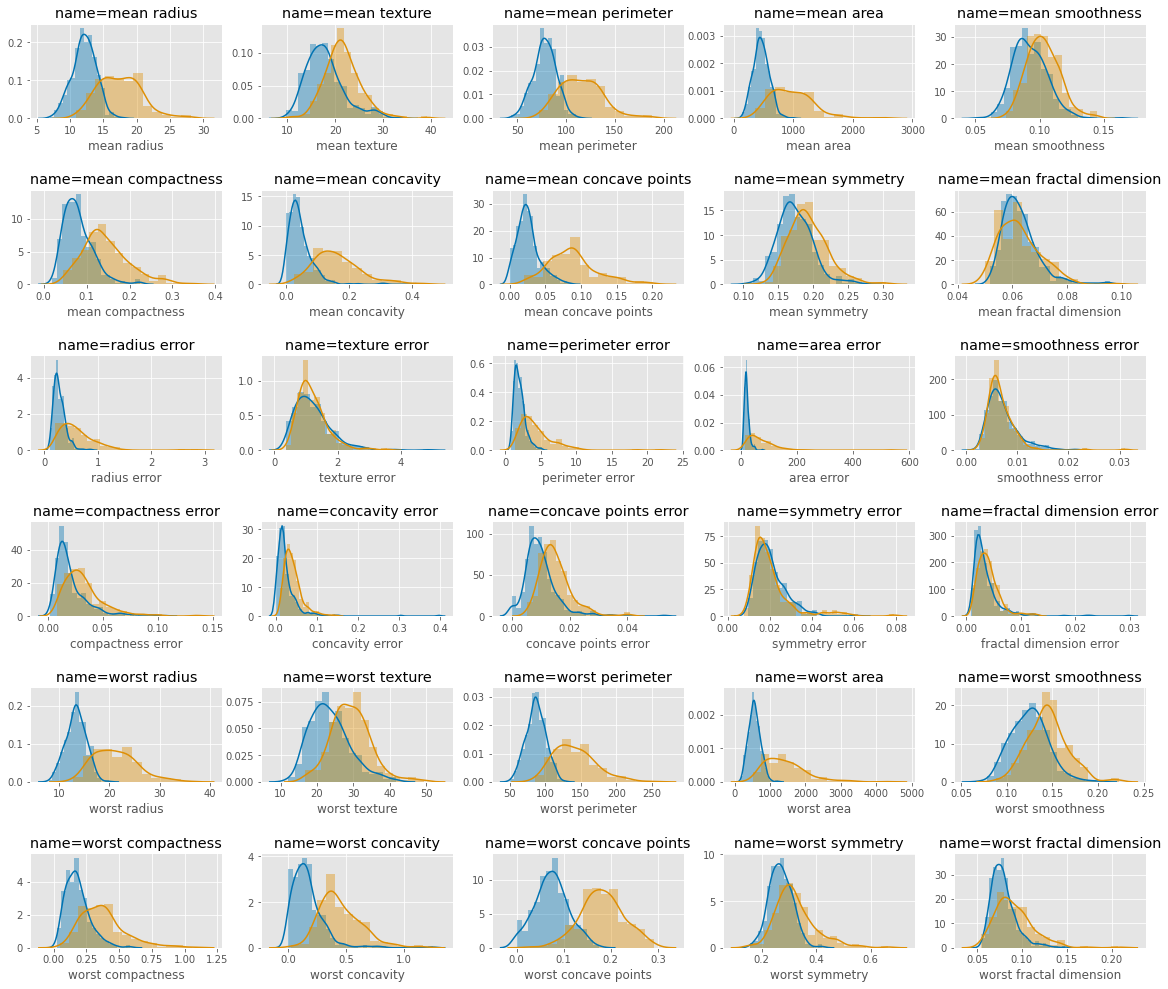

In [0]:
fig, axes = plt.subplots(6, 5, figsize=(20, 17))
fig.subplots_adjust(hspace=0.75)

for (ax, col) in zip(axes.ravel(), dataset.columns[:-1]):
    sns.distplot(dataset.loc[dataset['target'] == 'benign', col], ax=ax)
    sns.distplot(dataset.loc[dataset['target'] == 'malignant', col], ax=ax)
    ax.set_title('name={}'.format(col))

Based on the plot above, we see that several features could classify the target pretty well independently, such as mean radius and worst concave points. Now, we will look at the empirical cumulative distribution function for each class (benign and malignant) and compare to its normal distribution.

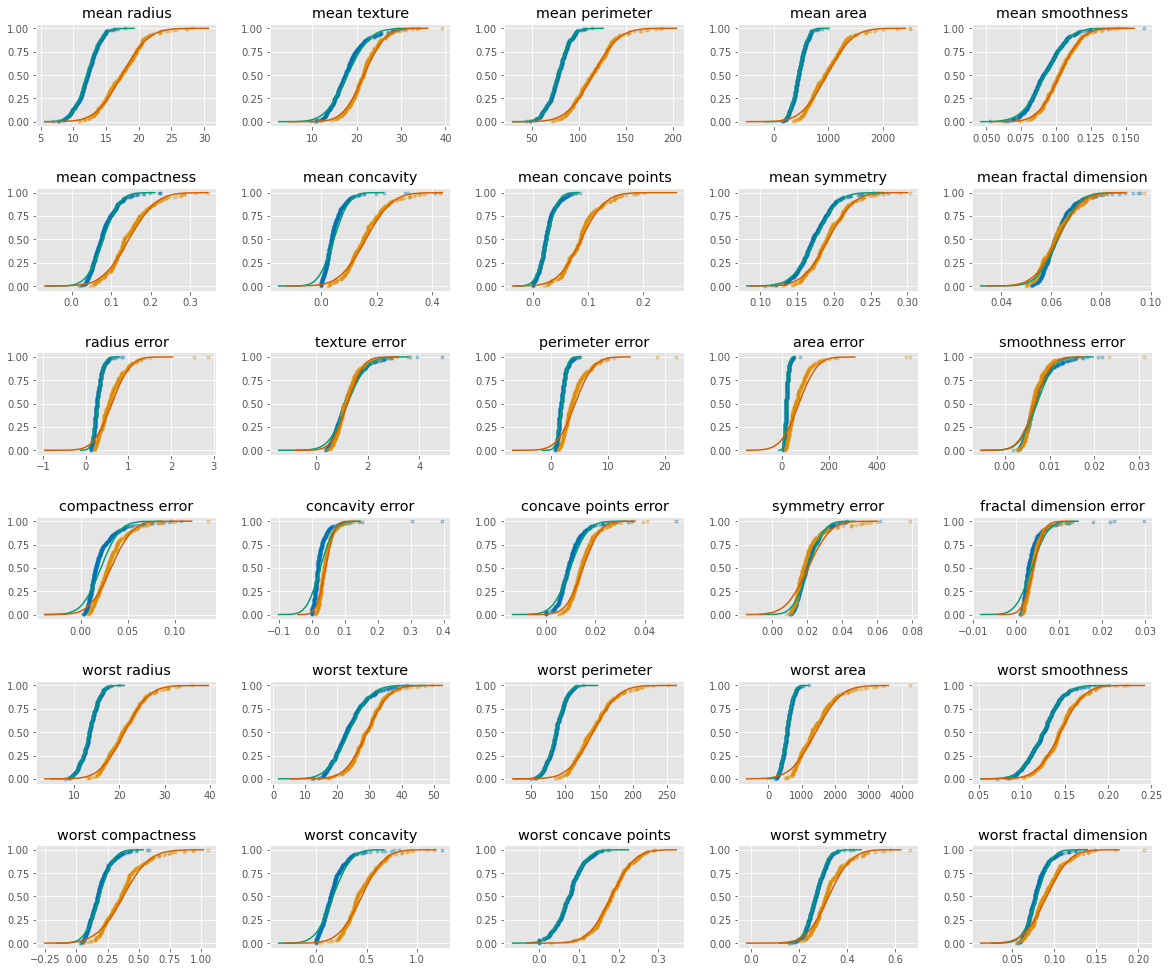

In [0]:
fig, axes = plt.subplots(6, 5, figsize=(20, 17))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for (col, ax) in zip(dataset.columns[:-1], axes.ravel()):
    n = dataset.size
    x_benign, y_benign = ecdf(dataset.loc[dataset['target'] == 'benign', col])
    x_malignant, y_malignant = ecdf(dataset.loc[dataset['target'] == 'malignant', col])
    normal_benign = np.random.normal(x_benign.mean(), x_benign.std(), size=n)
    normal_malignant = np.random.normal(x_malignant.mean(), x_malignant.std(), size=n)
    x_norm_benign, y_norm_benign = ecdf(normal_benign)
    x_norm_malignant, y_norm_malignant = ecdf(normal_malignant)
    ax.plot(x_benign, y_benign, '.', alpha=0.3)
    ax.plot(x_malignant, y_malignant, '.', alpha=0.3)
    ax.plot(x_norm_benign, y_norm_benign)
    ax.plot(x_norm_malignant, y_norm_malignant)
    ax.set_title(col)

Here, we get the empirical cumulative distribution function for each column seperated for each class. Compare to the histrogram before, we see which column that have the same distribution for benign and malignant, which means that it probably won't be a good feature for our predictors. So, if we want to eliminate several features to prevent the curse of dimensionality, we will choose these features. Until then, let's keep it untouch.

Now, what about the correlation between features. How strong each feature related to each other.

In [0]:
correlation = dataset.iloc[:, :-1].corr()
correlation

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Certainly hard to read all of the information above in a huge table. Better to visualize it with seaborn heatmap.

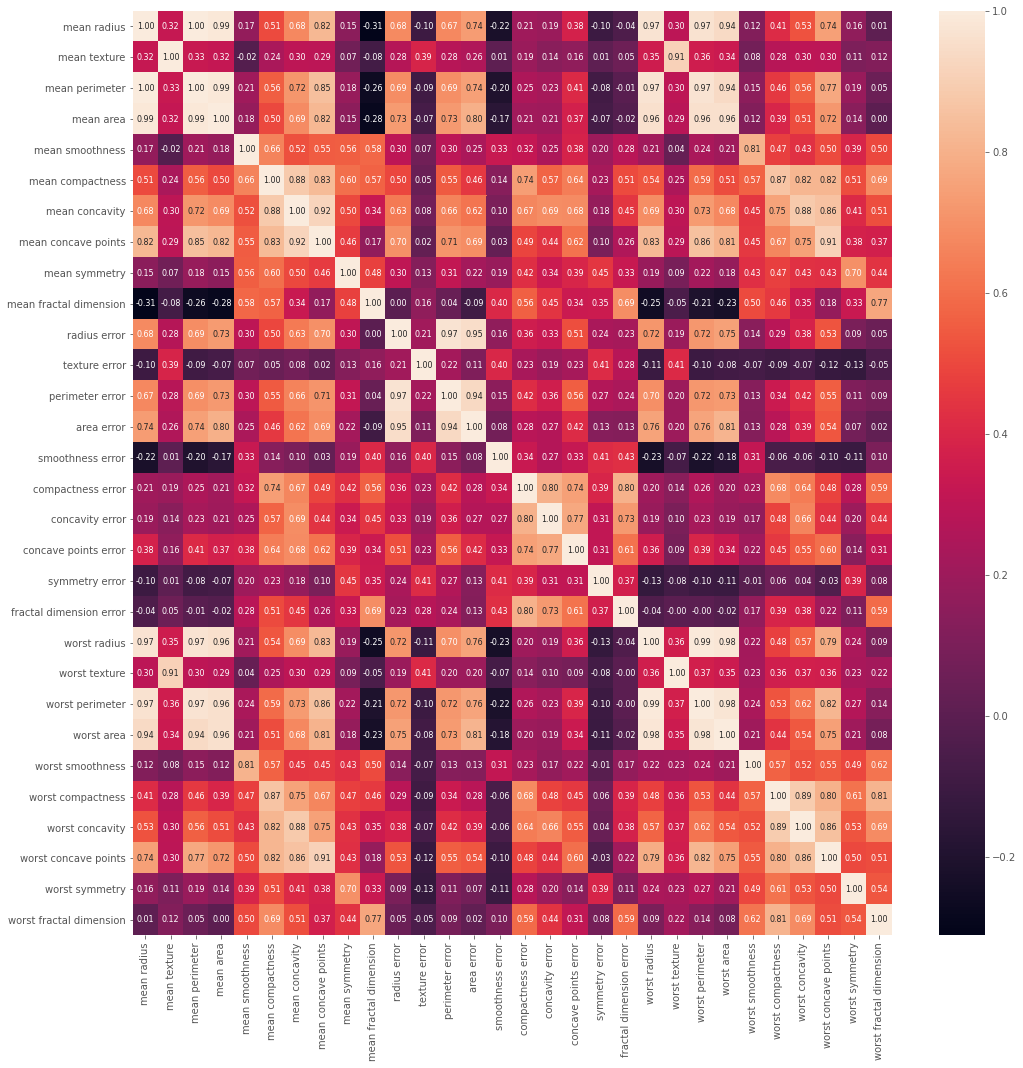

In [0]:
plt.figure(figsize=(17, 17))
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={'fontsize': 8});

Here we saw some features with white color, which means that they have strong correlation. To undestand it better, we will simplify it more by choosing which features with correlation greater than 0.9 or less than -0.9.

In [0]:
strong_pairs = []
for num, (i, row) in enumerate((np.abs(correlation) > 0.9).iterrows()):
    for j, element in row[num:].iteritems():
        if i == j:
            continue
        else:
            if element:
                strong_pairs.append((i, j))

In [51]:
strong_pairs

[('mean radius', 'mean perimeter'),
 ('mean radius', 'mean area'),
 ('mean radius', 'worst radius'),
 ('mean radius', 'worst perimeter'),
 ('mean radius', 'worst area'),
 ('mean texture', 'worst texture'),
 ('mean perimeter', 'mean area'),
 ('mean perimeter', 'worst radius'),
 ('mean perimeter', 'worst perimeter'),
 ('mean perimeter', 'worst area'),
 ('mean area', 'worst radius'),
 ('mean area', 'worst perimeter'),
 ('mean area', 'worst area'),
 ('mean concavity', 'mean concave points'),
 ('mean concave points', 'worst concave points'),
 ('radius error', 'perimeter error'),
 ('radius error', 'area error'),
 ('perimeter error', 'area error'),
 ('worst radius', 'worst perimeter'),
 ('worst radius', 'worst area'),
 ('worst perimeter', 'worst area')]

Above, we have a list of tuples with each tuple contains two features that have strong coefficient of determination. Later, we will see if there any differences for our metrics performance with or without these features.

---

## Base Predictive Modeling

In this section, we will perform predictive modeling without hyperparameter tuning and preprocessing step, to let us know how preprocessing step and hyperparameter tuning would be beneficial for our quest to get the highest performance.